# TFIDF
- [MLB & Prepare](#MLB-&-Prepare)</BR>
- [Body](#Body)</BR>
- [Title](#Title)</BR>
- [Concatenation](#Concatenation)</BR>

In [1]:
import os
import time
from joblib import dump, load

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

data_path = "..\\data\\stackoverflow\\"
model_path = data_path + "models\\"
tb_path = os.path.join(model_path, "tb_logs")

np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = "{:,.2f}".format

# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
print("Tensorflow version: ", tf.__version__)
print("Tensorflow GPU detection: ", tf.config.list_physical_devices('GPU'))

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
Tensorflow version:  2.6.0-dev20210413
Tensorflow GPU detection:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
def tb_logdir(name=None):
    if name:
        return os.path.join(tb_path, name)        
    else:
        current_time = time.strftime("mlp_%Y%m%d-%H%M%S")
        return os.path.join(tb_path, current_time)

# MLB & Prepare
- [Toc](#TFIDF)

In [3]:
mlb = MultiLabelBinarizer()
df_tags = pd.read_pickle(data_path + 'Top_Tags.pkl')
df_tags_test = pd.read_pickle(data_path + 'Top_Tags_test.pkl')
df_tags_full = pd.concat([df_tags,df_tags_test])
mlb.fit_transform(df_tags_full['Tags_T50'])

y_tags = mlb.transform(df_tags['Tags_T50'])
y_tags_test = mlb.transform(df_tags_test['Tags_T50'])

In [4]:
# y_dict = load(data_path + 'y_dict_top50.joblib')
title_vectorizer = load(model_path + 'lemma_title_vectorizer.joblib')
body_vectorizer = load(model_path + 'lemma_body_vectorizer_12.joblib')

In [5]:
df_lemma = pd.read_pickle(data_path + 'nltk_lemma_stop.pkl')
df_lemma_test = pd.read_pickle(data_path + 'nltk_lemma_stop_test.pkl')
df_lemma['Title'] = df_lemma['Title'].apply(lambda row: ' '.join(row))
df_lemma['Body'] = df_lemma['Body'].apply(lambda row: ' '.join(row))
df_lemma_test['Title'] = df_lemma_test['Title'].apply(lambda row: ' '.join(row))
df_lemma_test['Body'] = df_lemma_test['Body'].apply(lambda row: ' '.join(row))

In [6]:
X_title = title_vectorizer.transform(df_lemma['Title'])
X_title_test = title_vectorizer.transform(df_lemma_test['Title'])
X_body = body_vectorizer.transform(df_lemma['Body'])
X_body_test = body_vectorizer.transform(df_lemma_test['Body'])

# Body
- [Toc](#TFIDF)

In [8]:
metrics = [
    tf.keras.metrics.PrecisionAtRecall(0.5,name='patr'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.FalseNegatives(name='fn'), 
    keras.metrics.TruePositives(name='tp'),
#     keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]
LABEL_SMOOTHING = 0
optimizer = keras.optimizers.Adam(learning_rate=0.003)
loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING)

In [8]:
COUNT = 100000
SPLIT_RATIO = .8
BATCH_SIZE = 16
SHUFFLE_BUFFER_SIZE = 64

ds_body =  tf.data.Dataset.from_tensor_slices((X_body[:COUNT].toarray(), y_tags[:COUNT]))
ds_body_train, ds_body_valid = ds_body.take(ds_body.cardinality().numpy()*SPLIT_RATIO), ds_body.skip(ds_body.cardinality().numpy()*SPLIT_RATIO)
body_train_data = ds_body_train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
body_valid_data = ds_body_valid.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [9]:
DIM = 48
DROPOUT = .4

model = keras.Sequential([
    
    layers.Dense(DIM, input_shape=(5000,), activation='relu',
#                  kernel_initializer="he_normal",
#                  kernel_regularizer=keras.regularizers.l1(0.000003)
                ),
#     layers.BatchNormalization(),
    layers.Dropout(DROPOUT),

    layers.Dense(DIM, activation='relu', 
#                  kernel_initializer="he_normal",
#                  kernel_regularizer=keras.regularizers.l1(0.000003)
                ),
    layers.Dropout(DROPOUT),
    layers.Dense(51, activation='sigmoid'),
])

    
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING),
    metrics=metrics,
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 48)                240048    
_________________________________________________________________
dropout (Dropout)            (None, 48)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 48)                2352      
_________________________________________________________________
dropout_1 (Dropout)          (None, 48)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 51)                2499      
Total params: 244,899
Trainable params: 244,899
Non-trainable params: 0
_________________________________________________________________


In [10]:
logdir = tb_logdir('tfidf_body_mlp')

tb_callback = tf.keras.callbacks.TensorBoard(
        logdir,
        update_freq='batch',
        )
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=4,
    restore_best_weights=True,
    )
history = model.fit(
    body_train_data,
    epochs=20,
    validation_data=body_valid_data,
    validation_steps=3,
    callbacks=[tb_callback, es_callback],
)

Epoch 1/20
4821/4821 [==============================] - 64s 13ms/step - loss: 0.1206 - patr: 0.1646 - recall: 0.0838 - auc: 0.8162 - fp: 6021.9757 - fn: 51324.7312 - tp: 6002.3511 - accuracy: 0.9673 - precision: 0.3928 - val_loss: 0.0671 - val_patr: 0.5441 - val_recall: 0.3088 - val_auc: 0.9550 - val_fp: 11.0000 - val_fn: 47.0000 - val_tp: 21.0000 - val_accuracy: 0.9763 - val_precision: 0.6562
Epoch 2/20
4821/4821 [==============================] - 63s 13ms/step - loss: 0.0786 - patr: 0.4371 - recall: 0.2361 - auc: 0.9263 - fp: 5835.7012 - fn: 43447.9177 - tp: 13879.0429 - accuracy: 0.9749 - precision: 0.7020 - val_loss: 0.0623 - val_patr: 0.6429 - val_recall: 0.3088 - val_auc: 0.9598 - val_fp: 8.0000 - val_fn: 47.0000 - val_tp: 21.0000 - val_accuracy: 0.9775 - val_precision: 0.7241
Epoch 3/20
4821/4821 [==============================] - 65s 14ms/step - loss: 0.0741 - patr: 0.5011 - recall: 0.2746 - auc: 0.9364 - fp: 6154.9925 - fn: 41310.5838 - tp: 16016.3762 - accuracy: 0.9758 - prec

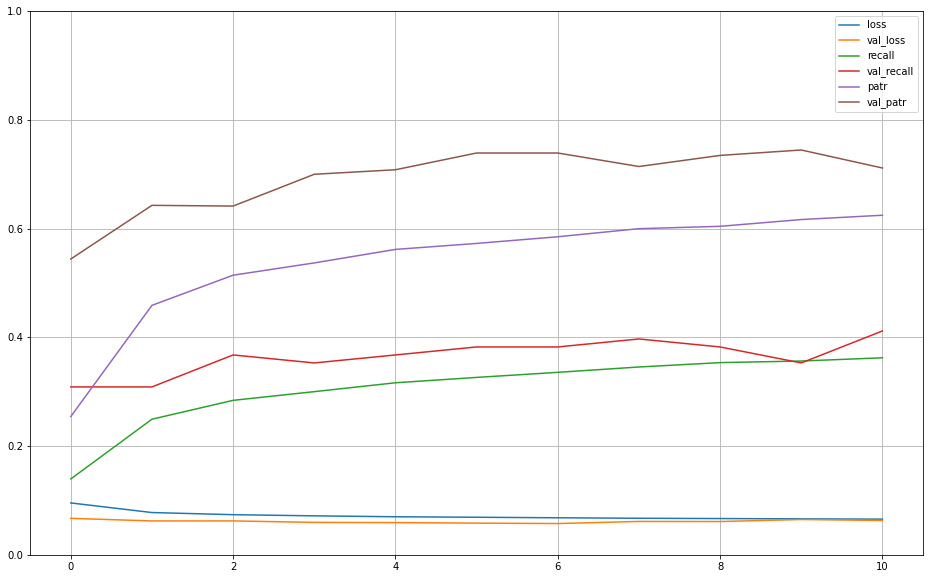

In [11]:
cols_1 = ['loss', 'val_loss', 'recall', 'val_recall', 'patr', 'val_patr' ]
pd.DataFrame(history.history)[cols_1].plot(figsize=(16,10))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [13]:
model.evaluate(X_body_test.toarray(),y_tags_test)

433/433 [==============================] - 7s 17ms/step - loss: 0.0667 - patr: 0.6335 - recall: 0.3455 - auc: 0.9494 - fp: 2120.0000 - fn: 13627.0000 - tp: 7193.0000 - accuracy: 0.9777 - precision: 0.7724: 0s - loss: 0.0666 - patr: 0.6339 - recall: 0.3459 - auc: 0.9495 - fp: 2076.0000 - fn: 13386.0000 - tp: 7079.0000 - accuracy: 0.9777 - precision: 0.7


[0.06670179218053818,
 0.6335075497627258,
 0.345485121011734,
 0.9494475722312927,
 2120.0,
 13627.0,
 7193.0,
 0.9776839017868042,
 0.7723612189292908]

# Title
- [Toc](#TFIDF)

In [16]:
COUNT = 100000
SPLIT_RATIO = .8
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 128
ds_title =  tf.data.Dataset.from_tensor_slices((X_title[:COUNT].toarray(), y_tags[:COUNT]))
ds_title_train, ds_title_valid = ds_title.take(ds_title.cardinality().numpy()*SPLIT_RATIO), ds_title.skip(ds_title.cardinality().numpy()*SPLIT_RATIO)
title_train_data = ds_title_train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
title_valid_data = ds_title_valid.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [17]:
metrics = [
    tf.keras.metrics.PrecisionAtRecall(0.5,name='patr'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.FalseNegatives(name='fn'), 
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
#     keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]
LABEL_SMOOTHING = 0
optimizer = keras.optimizers.Adam(learning_rate=0.003)
loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING)

In [18]:
DIM = 24
DROPOUT = .25

model = keras.Sequential([
    
    layers.Dense(DIM, input_shape=(1000,), activation='relu',
#                  kernel_initializer="he_normal",
#                  kernel_regularizer=keras.regularizers.l1(0.000003)
                ),
#     layers.BatchNormalization(),
    layers.Dropout(DROPOUT),

    layers.Dense(DIM, activation='relu', 
#                  kernel_initializer="he_normal",
#                  kernel_regularizer=keras.regularizers.l1(0.000003)
                ),
    layers.Dropout(DROPOUT),
    layers.Dense(51, activation='sigmoid'),
])

    
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING),
    metrics=metrics,
)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 24)                24024     
_________________________________________________________________
dropout_4 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 24)                600       
_________________________________________________________________
dropout_5 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 51)                1275      
Total params: 25,899
Trainable params: 25,899
Non-trainable params: 0
_________________________________________________________________


In [19]:
tb_callback = keras.callbacks.TensorBoard(tb_logdir())
history = model.fit(
    title_train_data,
    epochs=7,
    validation_data=title_valid_data,
    validation_steps=3,
#     callbacks=[tb_callback],
)

Epoch 1/7
1206/1206 [==============================] - 32s 25ms/step - loss: 0.1847 - patr: 0.0719 - recall: 0.0393 - auc: 0.6980 - fp: 11955.0655 - fn: 54985.7341 - tp: 2449.3654 - accuracy: 0.9558 - precision: 0.1411 - val_loss: 0.0804 - val_patr: 0.3080 - val_recall: 0.1148 - val_auc: 0.9260 - val_fp: 8.0000 - val_fn: 239.0000 - val_tp: 31.0000 - val_accuracy: 0.9748 - val_precision: 0.7949
Epoch 2/7
1206/1206 [==============================] - 29s 24ms/step - loss: 0.0875 - patr: 0.3279 - recall: 0.1728 - auc: 0.8986 - fp: 3940.8119 - fn: 47167.2693 - tp: 10267.2701 - accuracy: 0.9740 - precision: 0.7173 - val_loss: 0.0694 - val_patr: 0.4789 - val_recall: 0.2593 - val_auc: 0.9450 - val_fp: 13.0000 - val_fn: 200.0000 - val_tp: 70.0000 - val_accuracy: 0.9782 - val_precision: 0.8434
Epoch 3/7
1206/1206 [==============================] - 19s 16ms/step - loss: 0.0812 - patr: 0.4187 - recall: 0.2321 - auc: 0.9147 - fp: 4441.8840 - fn: 43984.3571 - tp: 13450.4408 - accuracy: 0.9754 - prec

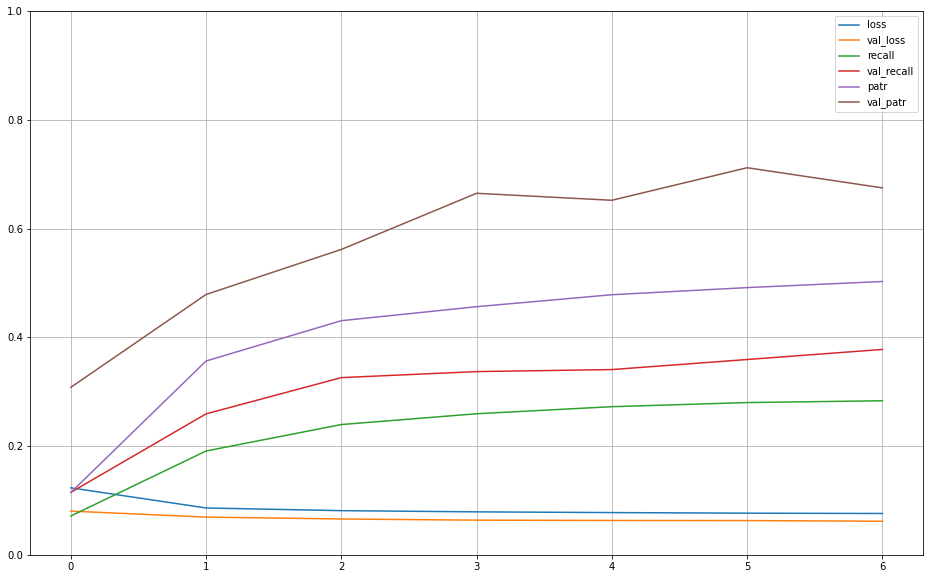

In [26]:
cols_1 = ['loss', 'val_loss', 'recall', 'val_recall', 'patr', 'val_patr' ]
pd.DataFrame(history.history)[cols_1].plot(figsize=(16,10))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
model.evaluate(X_title_test.toarray(),y_tags_test)

# Concatenation
- [Toc](#TFIDF)

In [8]:
LABEL_SMOOTHING = 0
optimizer = keras.optimizers.Adam(learning_rate=0.003)
loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING)

In [9]:
COUNT=100000
SPLIT_RATIO = .8
BATCH_SIZE = 16
SHUFFLE_BUFFER_SIZE = 128
ds_concat =  tf.data.Dataset.from_tensor_slices(((X_title[:COUNT].toarray(), X_body[:COUNT].toarray()), y_tags[:COUNT]))
ds_concat_train, ds_concat_valid = ds_concat.take(ds_concat.cardinality().numpy()*SPLIT_RATIO), ds_concat.skip(ds_concat.cardinality().numpy()*SPLIT_RATIO)
concat_train_data = ds_concat_train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
concat_valid_data = ds_concat_valid.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [10]:
metrics = [
    tf.keras.metrics.PrecisionAtRecall(0.5,name='patr'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.FalseNegatives(name='fn'), 
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
#     keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [11]:
DIM_TITLE = 24
# DROPOUT_TITLE = .25
DROPOUT_TITLE = .20
DIM_BODY = 48
# DROPOUT_BODY = .4
DROPOUT_BODY = .35
DROPOUT_CONCAT = .25

input_title = tf.keras.layers.Input(shape=(1000,), name="title_input")
hidden_title_1 = tf.keras.layers.Dense(DIM_TITLE, activation='relu')(input_title)
dropout_title_1 = tf.keras.layers.Dropout(DROPOUT_TITLE)(hidden_title_1)
# hidden_title_2 = tf.keras.layers.Dense(DIM_TITLE, activation='relu')(dropout_title_1)
# dropout_title_2 = tf.keras.layers.Dropout(DROPOUT)(hidden_title_2)

input_body = tf.keras.layers.Input(shape=(5000,), name="body_input")
hidden_body_1 = tf.keras.layers.Dense(DIM_BODY, activation='relu')(input_body)
dropout_body_1 = tf.keras.layers.Dropout(DROPOUT_BODY)(hidden_body_1)
# hidden_body_2 = tf.keras.layers.Dense(DIM_BODY, activation='relu')(dropout_body_1)
# dropout_body_2 = tf.keras.layers.Dropout(DROPOUT)(hidden_body_2)

# concat = tf.keras.layers.concatenate([dropout_title_2, dropout_body_2])
concat = tf.keras.layers.concatenate([dropout_title_1, dropout_body_1])
hidden_concat = tf.keras.layers.Dense(48, activation='relu')(concat)
dropout_concat = tf.keras.layers.Dropout(DROPOUT_CONCAT)(hidden_concat)

# output = tf.keras.layers.Dense(51, activation='sigmoid')(concat)
output = tf.keras.layers.Dense(51, activation='sigmoid')(dropout_concat)

model = tf.keras.Model(inputs=[input_title, input_body], outputs=[output])

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING),
    metrics=metrics,
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title_input (InputLayer)        [(None, 1000)]       0                                            
__________________________________________________________________________________________________
body_input (InputLayer)         [(None, 5000)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 24)           24024       title_input[0][0]                
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 48)           240048      body_input[0][0]                 
______________________________________________________________________________________________

In [12]:
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=4,
    restore_best_weights=True,
    )

tb_callback = keras.callbacks.TensorBoard(tb_logdir())
history = model.fit(
    concat_train_data,
    epochs=10,
    validation_data=concat_valid_data,
#     validation_steps=3,
    callbacks=[es_callback],
)

Epoch 1/7
4821/4821 [==============================] - 65s 13ms/step - loss: 0.1071 - patr: 0.2609 - recall: 0.1802 - auc: 0.8591 - fp: 6716.7478 - fn: 44214.0446 - tp: 13112.5168 - accuracy: 0.9706 - precision: 0.5446 - val_loss: 0.0556 - val_patr: 0.7731 - val_recall: 0.4510 - val_auc: 0.9668 - val_fp: 3051.0000 - val_fn: 15799.0000 - val_tp: 12978.0000 - val_accuracy: 0.9808 - val_precision: 0.8097
Epoch 2/7
4821/4821 [==============================] - 61s 13ms/step - loss: 0.0609 - patr: 0.7045 - recall: 0.4275 - auc: 0.9559 - fp: 7204.3181 - fn: 32465.6124 - tp: 24862.0462 - accuracy: 0.9798 - precision: 0.7744 - val_loss: 0.0530 - val_patr: 0.8052 - val_recall: 0.4917 - val_auc: 0.9677 - val_fp: 3250.0000 - val_fn: 14628.0000 - val_tp: 14149.0000 - val_accuracy: 0.9818 - val_precision: 0.8132
Epoch 3/7
4821/4821 [==============================] - 61s 13ms/step - loss: 0.0564 - patr: 0.7584 - recall: 0.4745 - auc: 0.9629 - fp: 7536.3086 - fn: 29962.7905 - tp: 27364.2014 - accuracy

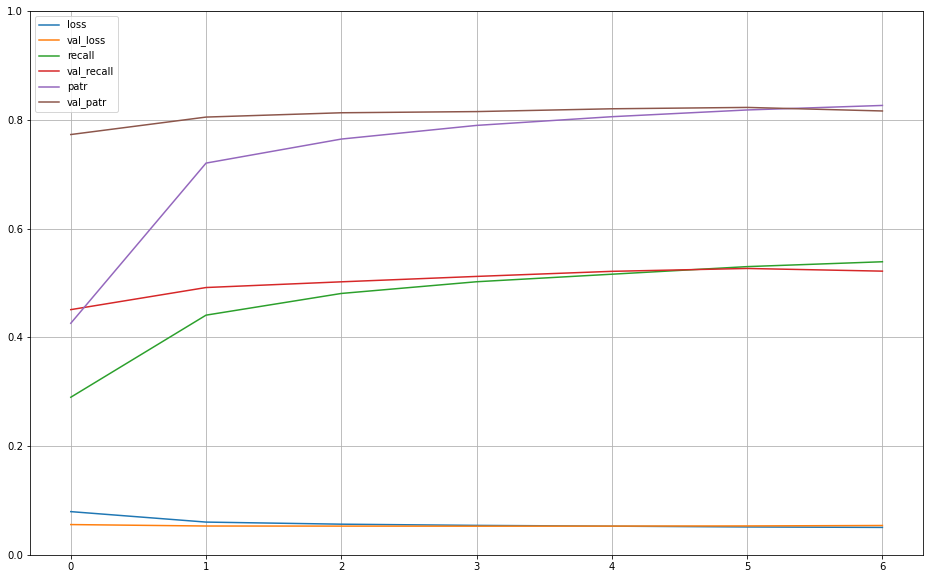

In [13]:
cols_1 = ['loss', 'val_loss', 'recall', 'val_recall', 'patr', 'val_patr' ]
pd.DataFrame(history.history)[cols_1].plot(figsize=(16,10))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [15]:
model.evaluate((X_title_test.toarray(), X_body_test.toarray()) , y_tags_test)

433/433 [==============================] - 4s 9ms/step - loss: 0.0545 - patr: 0.8152 - recall: 0.5207 - auc: 0.9611 - fp: 2726.0000 - fn: 9978.0000 - tp: 10842.0000 - accuracy: 0.9820 - precision: 0.7991


[0.05447794869542122,
 0.8151851296424866,
 0.5207492709159851,
 0.9611232280731201,
 2726.0,
 9978.0,
 10842.0,
 0.9819963574409485,
 0.7990860939025879]

In [7]:
save=False
if save:
    model.save(model_path + "TFIDF_model", overwrite=True, include_optimizer=True)
    saved_model = model
else:
    saved_model = tf.keras.models.load_model(model_path + "TFIDF_model")

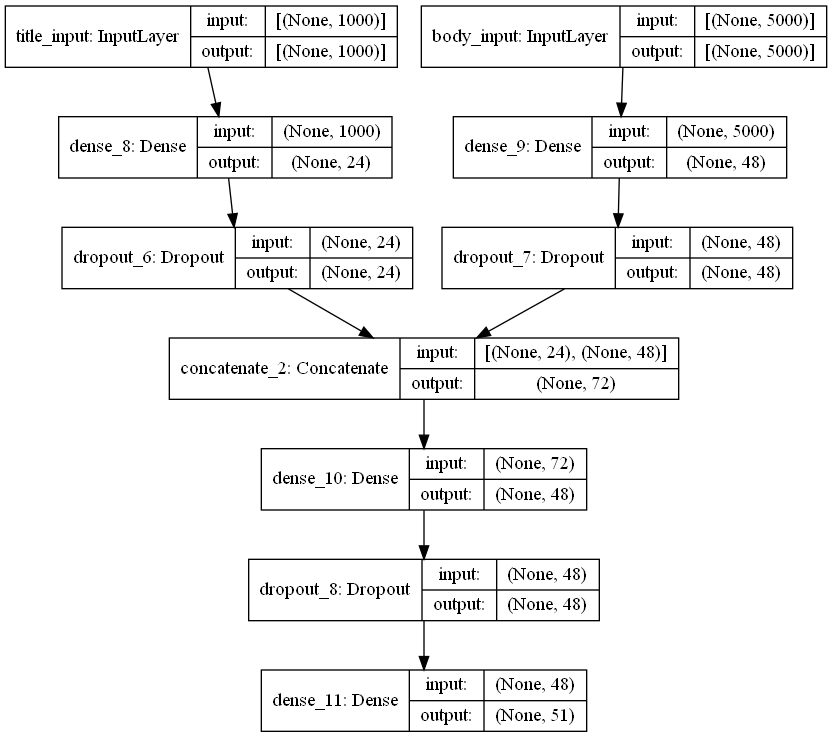

In [16]:
tf.keras.utils.plot_model(saved_model, show_shapes=True, dpi=96, to_file=data_path+"pict_MODEL_TFIDF.png")

In [25]:
ds_test =  tf.data.Dataset.from_tensor_slices(((X_title_test.toarray(), X_body_test.toarray()), )).batch(10)

In [26]:
res = model.predict(ds_test , y_tags_test)

In [27]:
mlb.inverse_transform(y_tags_test[2000:2010])

[('php', 'woocommerce', 'wordpress'),
 ('arrays', 'reactjs'),
 ('android', 'firebase', 'java'),
 ('other',),
 ('c',),
 ('mysql',),
 ('mysql', 'sql'),
 ('numpy', 'pandas', 'python'),
 ('javascript', 'typescript'),
 ('firebase', 'javascript')]

In [28]:
threshold = .2
tmp= pd.DataFrame(res[2000:2010]).applymap(lambda x:1 if x>threshold else 0)
mlb.inverse_transform(tmp.values)

[('php', 'woocommerce', 'wordpress'),
 ('arrays', 'javascript', 'reactjs'),
 ('android', 'firebase'),
 ('other', 'python'),
 ('c', 'c++'),
 ('mysql', 'php', 'sql'),
 ('mysql', 'sql', 'sql-server'),
 ('numpy', 'python'),
 ('c++', 'other'),
 ('firebase', 'javascript')]

In [49]:
mlb.inverse_transform(y_test[8750:8760])

[('javascript', 'python'),
 ('java',),
 ('other',),
 ('c++',),
 ('java',),
 ('python',),
 ('other',),
 ('bash',),
 ('dataframe', 'list', 'pandas', 'python'),
 ('css', 'html')]

In [51]:
res = model.predict(X_test[8750:8760])
for z in np.arange(res.shape[0]):
    classes = ""
    for r in np.arange(len(mlb.classes_)):
        if res[z][r]>.15:
            classes = classes + mlb.classes_[r] + ", "
    print("classe: ", classes )

classe:  other, python, 
classe:  arrays, javascript, python, 
classe:  python, 
classe:  c++, rust, 
classe:  java, 
classe:  python, 
classe:  javascript, sql, 
classe:  bash, other, python, 
classe:  dataframe, pandas, python, 
classe:  javascript, reactjs, 


In [54]:
df_tags_test[8750:8760]

,Tags_T100,Tags_T50,Tags_T10
8750,"[javascript, python]","[javascript, python]","[javascript, python]"
8751,[java],[java],[java]
8752,[other],[other],[other]
8753,[c++],[c++],[c++]
8754,"[java, database]",[java],[java]
8755,[python],[python],[python]
8756,[vba],[other],[other]
8757,"[bash, loops]",[bash],[other]
8758,"[python, pandas, list, dataframe]","[python, pandas, list, dataframe]","[python, pandas, dataframe]"
8759,"[html, css]","[html, css]",[other]


In [52]:
df_lemma_test.loc[8759,'Title']

'get hang indent dd tag cs also content'

In [53]:
df_lemma_test.loc[8759,'Body']

'page bunch definition list guy make style mockups word come brilliant idea render definition list term value hang indent admit actually brilliant difficult play around quite bit hang indent really necessary page becomes ugly grid suboptimal anyway page render break content appear hang indent style honor actually oppose method say hang indent hang keyword glitchy like render believe else'